Generative Adversarial Networks (GANs) are networks that work similarly to VAE's and are able to learn to generate similar images from applying noise on the training data. GANs are a backbone of generative models like DallE or Midjourney.

First, we'll load some data, classical MNIST in particular:


In [24]:
import torchvision
from torchvision import transforms
from torch.utils import data

transformations = torchvision.transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(0,1)
    # transforms.Lambda(lambda x: x * 64)
])

train_ds, test_ds = torchvision.datasets.MNIST(root='./data/vision',
                                               train=True,
                                               transform=transformations,
                                               download=True), \
                    torchvision.datasets.MNIST(root='./data/vision',
                                               train=False,
                                               transform=transformations,
                                               download=True)

# pin_memory allows dedicated faster paging of the data
# between CPU and GPU: https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/#pinned_host_memory
train_dl, test_dl = data.DataLoader(train_ds, 64, shuffle=True, pin_memory=True), \
    data.DataLoader(test_ds, 64, shuffle=False)

len(train_dl), len(test_dl)

(938, 157)

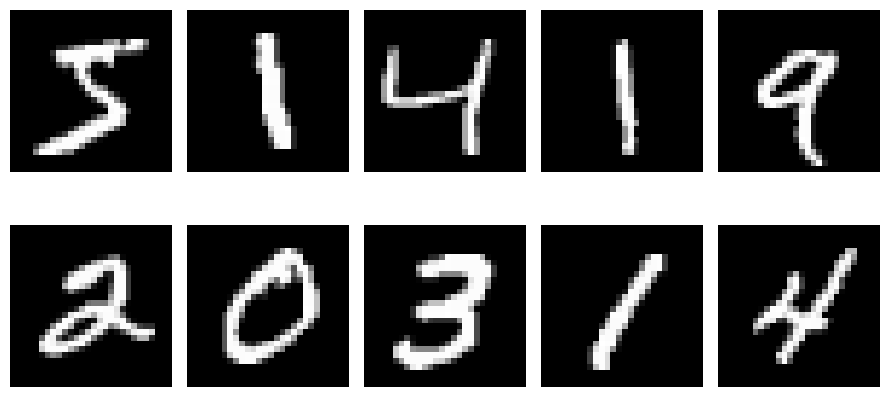

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,5,figsize=(9,5))
for i, data in enumerate(train_ds):
    if i == 10:
        break
    img, lbl = data
    axs[i % 2, i % 5].imshow(img[0],cmap="gray")
    axs[i % 2, i % 5].axis('off')
fig.tight_layout()

Now back to GANs. This type of networks consists of two NNs that communicate between each other and correct one another on the basis of predictions aquired from another network, hence the "advesarial" (competing) in the name of the algorithm. These two networks are:
* Discriminator: gets a generated image from the generator and predicts $P(valid|G(z,\theta))$ of a generated image being valid (0/1). For this function we're minimizing a binary cross-entropy based on true validity score and a predicted one.
* Generator: gets random noise on each step, tries to generate a random image in a way that maximizes the probability of a generated fake image belonging to the real dataset. Although it outputs numerical value, the cost function is yet again BCE, because we're optimizing parameters of the generator by applying gradient to: $\nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^m \log \left(1-D\left(G\left(\boldsymbol{z}^{(i)}\right)\right)\right)$ (we also minimize the second term, because we are aware of it being fake and that's why we subtract it from one, i.e. the more our discriminator thinks that the generated is valid, the less should the value be)

This minimax relation can be described as optimization problem as follows (where $G$ is the generator NN, $D$ - discriminator):
$$
\min _G \max _D V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text {data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

A more practical interpretation of the algorithm can be also seen in the official paper: https://arxiv.org/pdf/1406.2661 :

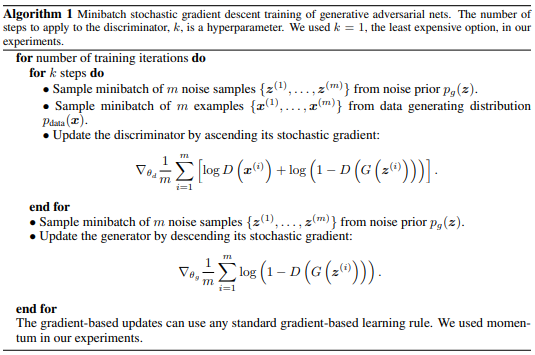



#### Now let's get down to coding the GAN
First of all, we're going to build a 3-layer Discriminator Network:

In [52]:
import torch
torch.cuda.empty_cache()

In [53]:
from torch import nn


class DNet(nn.Module):

    def __init__(self, hidden_d=1024, input_d=784, dropout=.2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.hid0 = nn.Sequential(
            nn.Linear(input_d,hidden_d),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.hid1 = nn.Sequential(
            nn.Linear(hidden_d,hidden_d // 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.hid2 = nn.Sequential(
            nn.Linear(hidden_d // 2,hidden_d // 4),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_d // 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hid0(x)
        x = self.hid1(x)
        x = self.hid2(x)
        return self.out(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
disc = DNet().to(device)
disc

DNet(
  (hid0): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
  )
  (hid1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
  )
  (hid2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

Next one is the Generator:

In [54]:
class GNet(nn.Module):

    def __init__(self, latent_d=100, hidden_d=256, out_d=784,
                 *args, **kwargs) -> None:
        """ 
        - latent_d: int
            - dimensions of noise vectors fed in the generator
        - hidden_d: int
            - hidden dimensions of linear layers. Multiplied by factor of
            2 on each new layer
        - out_d: int
            - dimensions of the output hidden layer
        """
        super().__init__(*args, **kwargs)

        self.hid0 = nn.Sequential(
            nn.Linear(latent_d, hidden_d),
            nn.GELU(),
        )
        self.hid1 = nn.Sequential(
            nn.Linear(hidden_d,hidden_d * 2),
            nn.GELU(),
        )
        self.hid2 = nn.Sequential(
            nn.Linear(hidden_d*2,hidden_d * 4),
            nn.GELU(),
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_d*4,out_d),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hid0(x)
        x = self.hid1(x)
        x = self.hid2(x)
        return self.out(x)
    
gen = GNet().to(device)
gen

GNet(
  (hid0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): GELU(approximate='none')
  )
  (hid1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): GELU(approximate='none')
  )
  (hid2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): GELU(approximate='none')
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

Next step is creating propreitary utility functions, such as noise generators that are going to be fed to generators and image vectorizer: 

In [55]:
from torch.autograd.variable import Variable

def gen_noise(size, latent_d=100):
    """ 
    Generating values from standard normal distribution
    that are treated as differentiable variables (their
    values are put after calculating the gradient)
    """
    return Variable(torch.randn(size,latent_d))

def vectorize_img(imageBatch, dims=784):
    return imageBatch.view(-1, dims)

def decode_img_vectors(vectorBatch, dims=784):
    # h, w dims, since upon vectorization we create a 1D vector of HxW size
    hw = int(dims**.5)
    
    return vectorBatch.view(vectorBatch.size(0), 1, hw, hw)

Upon each $n$ epoch within training we would also want to observe changes in generations. Hence, we write a seperate function that would generate a $28\times 28$ image from the noise and another for plotting 10 different generations

In [56]:
def inference(genNet, sample_size):
    """ 
    Generate samples from noise tensor of
    size sample_size. Returns a 28x28 MNIST image.
    """
    noise = gen_noise(sample_size)
    with torch.no_grad():
        pred = genNet(noise.to(device)).cpu()
    return decode_img_vectors(pred).squeeze(0)

In [57]:
def plot_inference(genNet, rows=2, cols=5):
    """ 
    Note that if (rows+cols)%2=0, then 
    images are not going to be displayed correctly
    because of overlaps between some of them
    """
    fig, axs = plt.subplots(rows,cols,figsize=(9,5))
    for i in range(10):
        genNet.eval()
        new_img = inference(genNet, 1)[0]
        axs[i % rows, i % cols].imshow(new_img,
                                       cmap="gray")
        axs[i % rows, i % cols].axis('off')
    genNet.train()
    fig.tight_layout()
    plt.show()

Loading up otimizers and the BCE loss

In [58]:
from torch.optim import Adam

trainingParams = {
    'lr': .001,
    'max_epochs': 30,
    'verbose': 2
}

Doptim = Adam(disc.parameters(), lr=trainingParams['lr'])
Goptim = Adam(gen.parameters(), lr=trainingParams['lr'])
criterion = nn.BCELoss().to(device)

Since it's a bit trickier than easier optimization techniques like ALS, it would be better to create two separate scripts for training the discriminator and the generator:

In [59]:
def train_discriminator(optim, real, fake):
    """ 
    - optim: torch.optim
        - expects Doptim
    - real: torch.Tensor
        - expects batch of real images
    - fake: torch.Tensor
        - expects batch of fake images
    """
    optim.zero_grad()

    # run inference on the real data
    pred_real = disc(real)
    loss_real = criterion(pred_real, torch.ones(real.size(0),1).to(device))
    loss_real.backward()

    # run inference on the fake data
    pred_fake = disc(fake)
    loss_fake = criterion(pred_fake, torch.zeros(real.size(0),1).to(device))
    loss_fake.backward()

    optim.step()

    # returning both BCE functions that need to be minimized
    return loss_real+loss_fake, pred_real, pred_fake

In [60]:
def train_generator(optim, fake):
    """ 
    - optim: torch.optim
        - expects Goptim
    - fake: torch.Tensor
        - fake or noise data
    """

    optim.zero_grad()
    
    # generate predictions and adjust
    # weights in order to adjust generations
    # to the expectation of the discriminator, hence
    # first off we're computing what the discriminator thinks
    # of the generated data / or noise if we're iterating
    # the first time
    pred = disc(fake)

    # the more we're closer to "fooling" the discriminator
    # to believe that our generation is indeed valid, 
    # the less is the gradient and the less we update
    # weights of the generator
    loss = criterion(pred, torch.ones(fake.size(0),1).to(device))
    loss.backward()
    optim.step()

    return loss

Once we've defined discriminator's and generator's training loops, we can set off to train both inside the general training loop:

100%|██████████| 938/938 [00:18<00:00, 51.76it/s]


epoch: 1 :: av. gen loss: 2.9498090744018555 :: av. disc loss: 0.7904965281486511 :: av. gen MSE (true vs fake): 0.10319191217422485


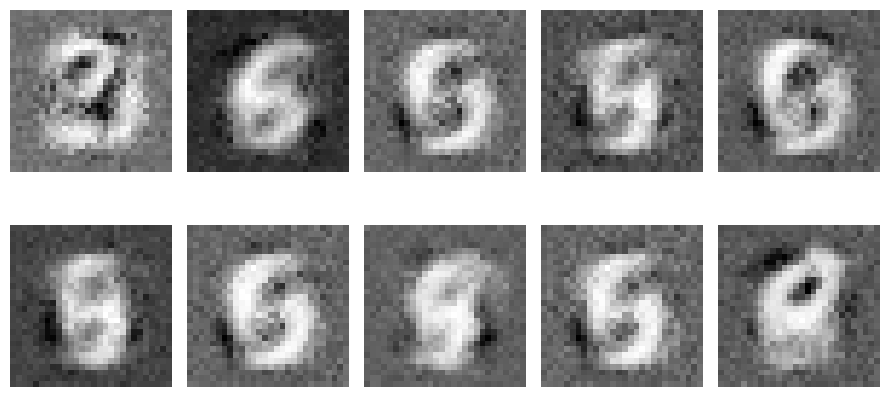

100%|██████████| 938/938 [00:18<00:00, 51.22it/s]


epoch: 3 :: av. gen loss: 5.128572463989258 :: av. disc loss: 0.22573712468147278 :: av. gen MSE (true vs fake): 0.15099196135997772


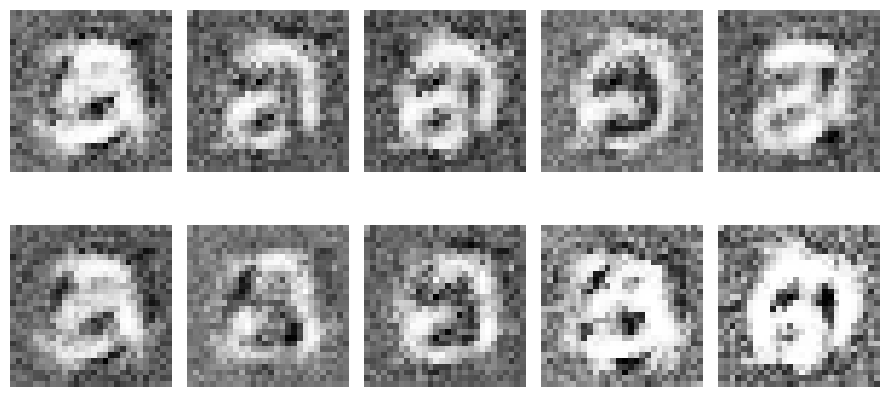

100%|██████████| 938/938 [00:18<00:00, 51.73it/s]


epoch: 5 :: av. gen loss: 5.755105972290039 :: av. disc loss: 0.14612051844596863 :: av. gen MSE (true vs fake): 0.15405479073524475


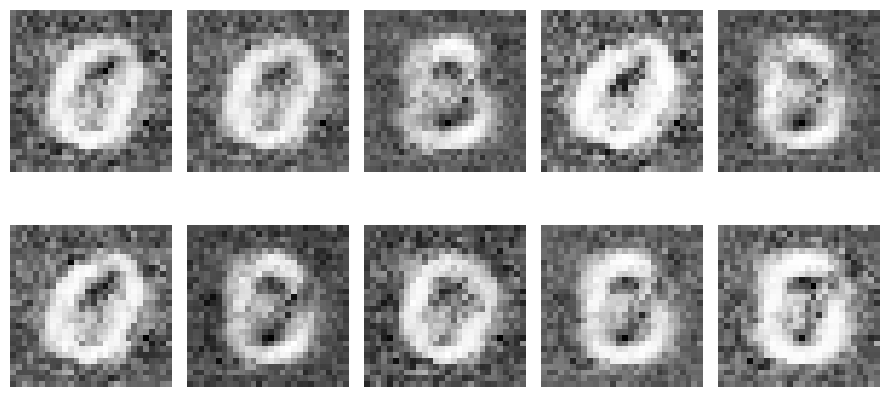

100%|██████████| 938/938 [00:18<00:00, 51.36it/s]


epoch: 7 :: av. gen loss: 6.196408271789551 :: av. disc loss: 0.1315755397081375 :: av. gen MSE (true vs fake): 0.14744916558265686


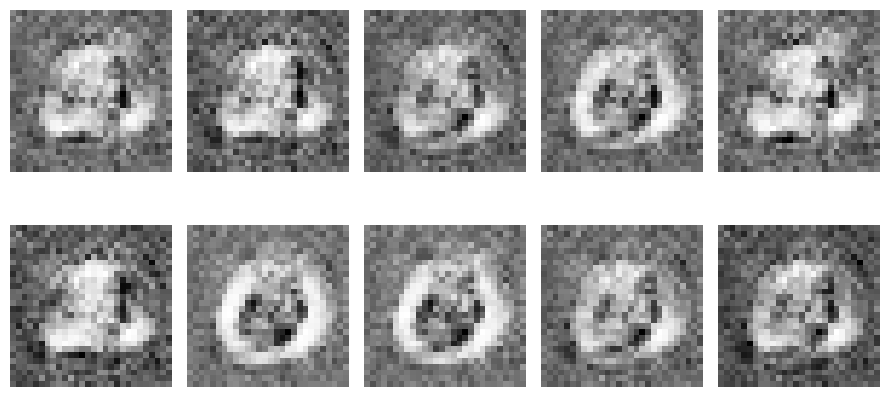

100%|██████████| 938/938 [00:17<00:00, 52.45it/s]


epoch: 9 :: av. gen loss: 6.261292934417725 :: av. disc loss: 0.1231900006532669 :: av. gen MSE (true vs fake): 0.13730278611183167


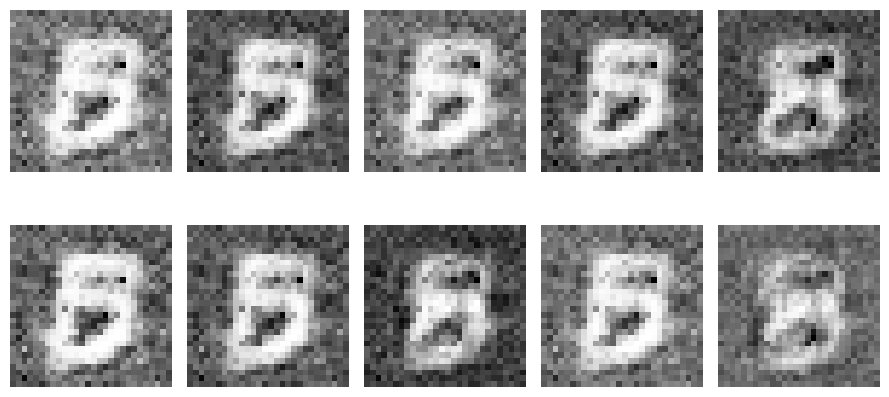

100%|██████████| 938/938 [00:18<00:00, 51.67it/s]


epoch: 11 :: av. gen loss: 6.419554710388184 :: av. disc loss: 0.13723260164260864 :: av. gen MSE (true vs fake): 0.14520597457885742


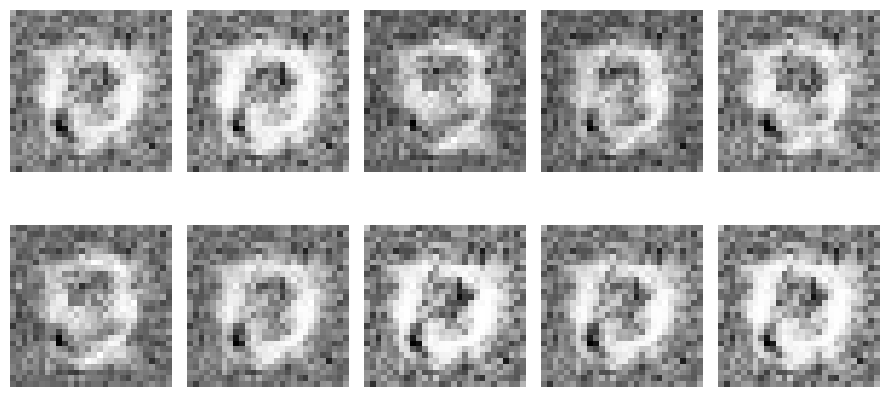

100%|██████████| 938/938 [00:18<00:00, 50.95it/s]


epoch: 13 :: av. gen loss: 6.006194591522217 :: av. disc loss: 0.15429262816905975 :: av. gen MSE (true vs fake): 0.1402648687362671


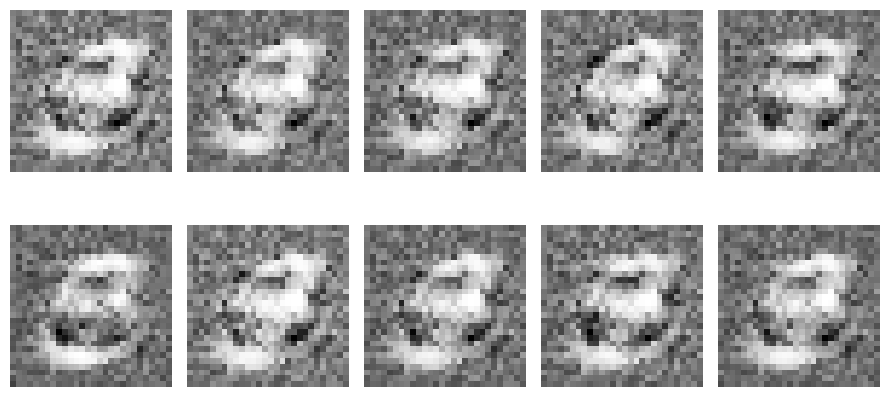

100%|██████████| 938/938 [00:17<00:00, 52.51it/s]


epoch: 15 :: av. gen loss: 5.523441791534424 :: av. disc loss: 0.17740151286125183 :: av. gen MSE (true vs fake): 0.137766495347023


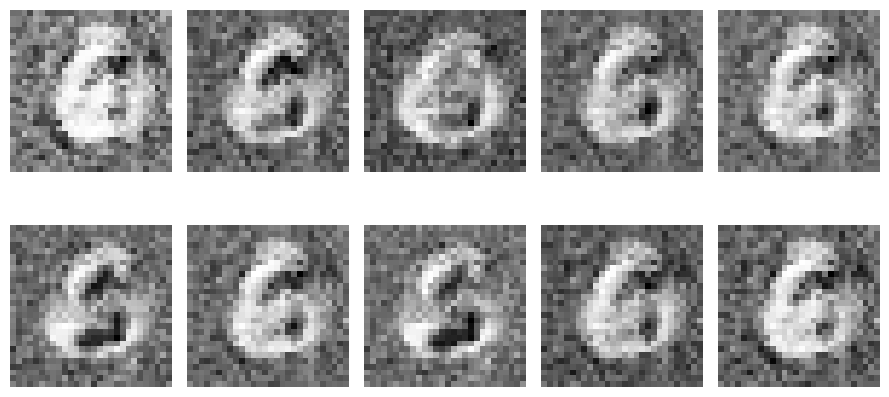

100%|██████████| 938/938 [00:17<00:00, 52.53it/s]


epoch: 17 :: av. gen loss: 4.727421760559082 :: av. disc loss: 0.20477278530597687 :: av. gen MSE (true vs fake): 0.13698741793632507


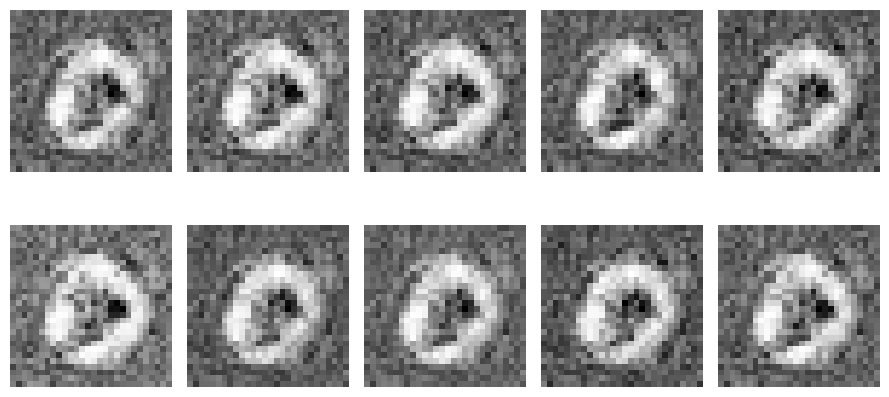

100%|██████████| 938/938 [00:17<00:00, 52.91it/s]


epoch: 19 :: av. gen loss: 3.9830126762390137 :: av. disc loss: 0.25697657465934753 :: av. gen MSE (true vs fake): 0.1327776312828064


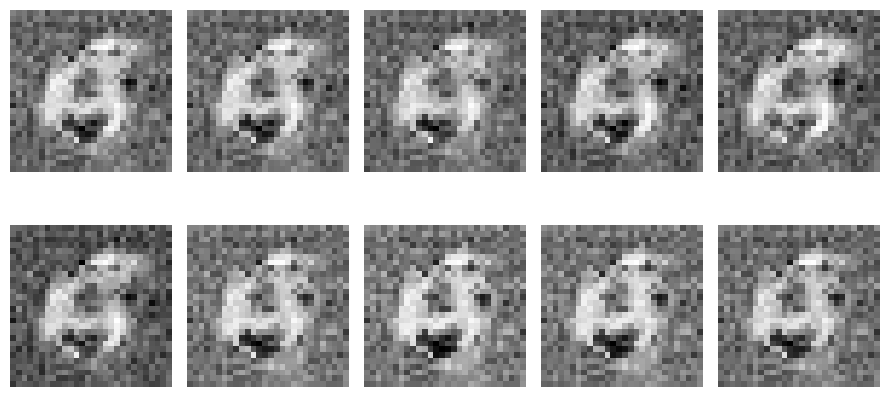

100%|██████████| 938/938 [00:17<00:00, 52.60it/s]


epoch: 21 :: av. gen loss: 3.6920554637908936 :: av. disc loss: 0.28546491265296936 :: av. gen MSE (true vs fake): 0.151997372508049


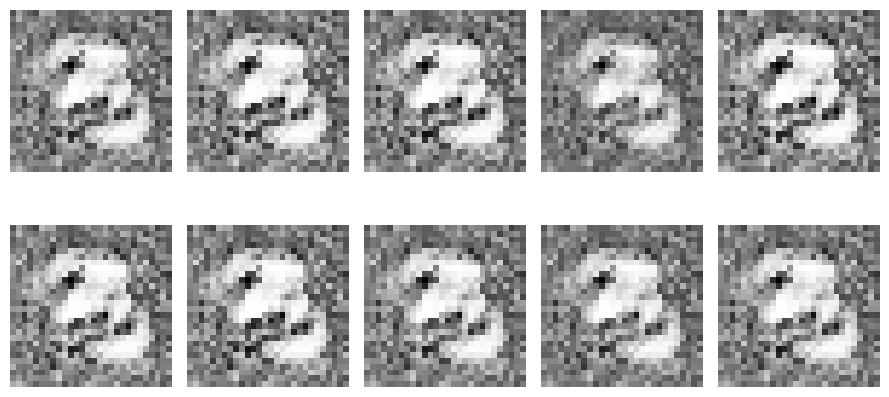

100%|██████████| 938/938 [00:17<00:00, 52.46it/s]


epoch: 23 :: av. gen loss: 3.4313974380493164 :: av. disc loss: 0.2904210090637207 :: av. gen MSE (true vs fake): 0.14329048991203308


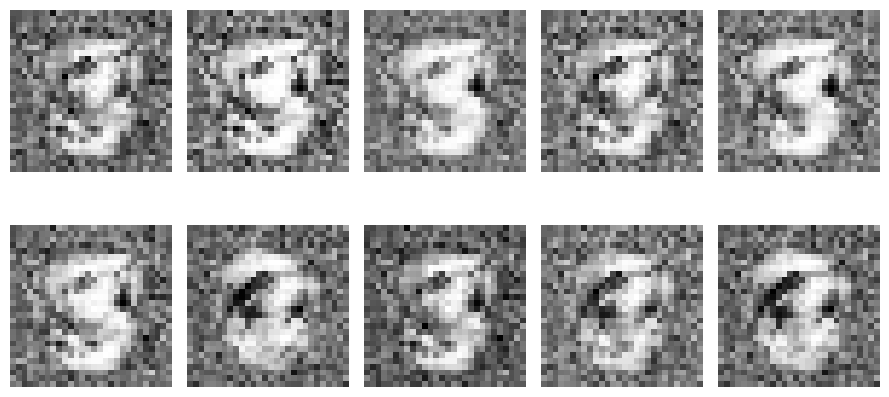

100%|██████████| 938/938 [00:18<00:00, 51.43it/s]


epoch: 25 :: av. gen loss: 3.461735486984253 :: av. disc loss: 0.2913840413093567 :: av. gen MSE (true vs fake): 0.16629453003406525


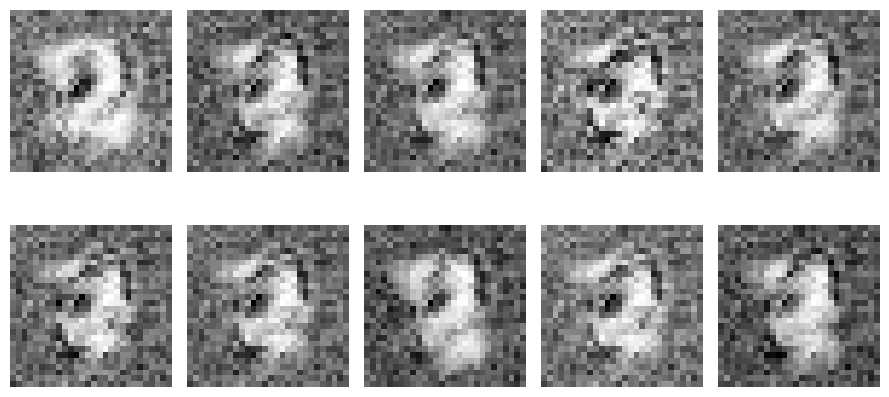

100%|██████████| 938/938 [00:17<00:00, 52.23it/s]


epoch: 27 :: av. gen loss: 3.5869483947753906 :: av. disc loss: 0.28932371735572815 :: av. gen MSE (true vs fake): 0.15738578140735626


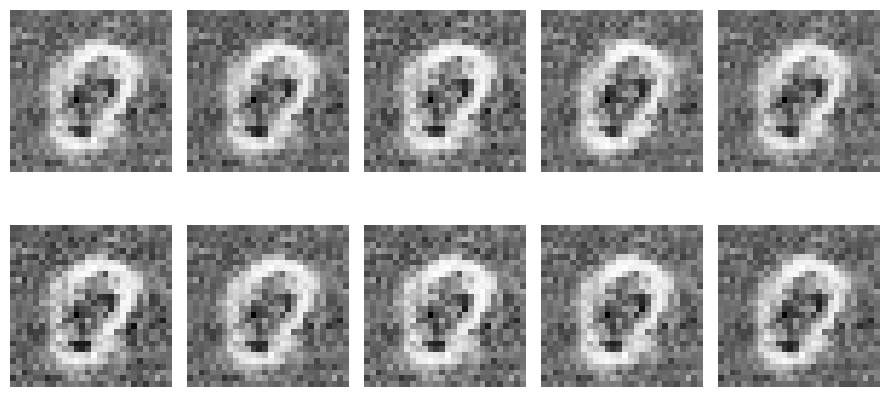

100%|██████████| 938/938 [00:18<00:00, 52.10it/s]


epoch: 29 :: av. gen loss: 3.4776430130004883 :: av. disc loss: 0.3160335123538971 :: av. gen MSE (true vs fake): 0.16771602630615234


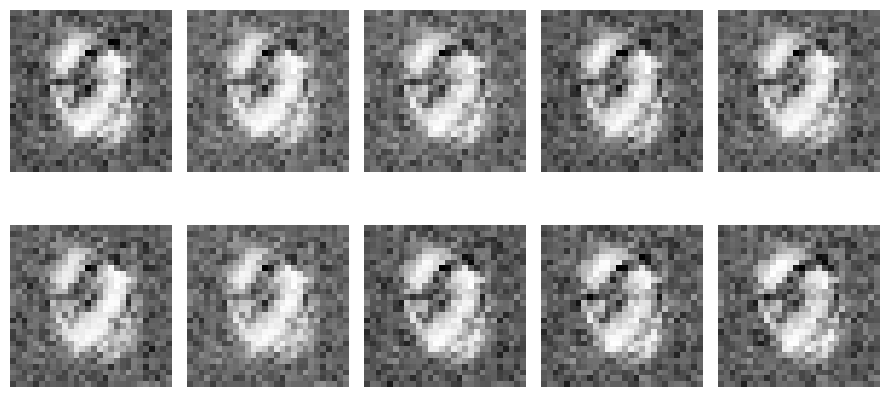

100%|██████████| 938/938 [00:18<00:00, 51.60it/s]


In [61]:
from tqdm import tqdm

av_d_Losses = []
av_g_Losses = []
av_MSE = []
for epoch in range(trainingParams['max_epochs']):

    g_losses, g_MSEs, d_losses = [], [], []
    for (imgBatch, labelBatch) in tqdm(train_dl):
        N = imgBatch.size(0)
        true_data = vectorize_img(imgBatch).to(device)

        # training the discriminator
        fake_data = gen(gen_noise(N).to(device)).detach()
        d_loss, d_pred_real, d_pred_fake = train_discriminator(
            Doptim,true_data,fake_data
        )
        d_losses.append(d_loss.cpu().detach())
        
        # training the generator
        # we're not applying .detach on fake data, because
        # we'll need to compute gradients for D(G(z))
        fake_data = gen(gen_noise(N).to(device))
        with torch.no_grad():
            mseLoss = nn.MSELoss()
            g_MSEs.append(mseLoss(true_data,fake_data).cpu())    
        g_loss = train_generator(Goptim, fake_data)
        g_losses.append(g_loss.cpu().detach())

    # logging losses for each network
    av_g_Losses.append(torch.vstack(g_losses).mean().item())
    av_d_Losses.append(torch.vstack(d_losses).mean().item())
    av_MSE.append(torch.vstack(g_MSEs).mean().item())
    if epoch % trainingParams['verbose'] == 0:
        print(f'epoch: {epoch+1} :: av. gen loss: {av_g_Losses[-1]} ::',
              f'av. disc loss: {av_d_Losses[-1]} ::',
              f'av. gen MSE (true vs fake): {av_MSE[-1]}')
        
        plot_inference(genNet=gen)


As a result of just 30 epochs (usually GANs are trained on way more epochs, moreover it's important to explore higher number of latent factors) an assumption about learning potential can be made, since the MSE error is quite stable and the average generator's BCE loss is decreasing over time, with an increase in the beggining, which is usually the case (since in the beggining the Discriminator does not possess sufficient knowledge about how to differ between fake and real data):

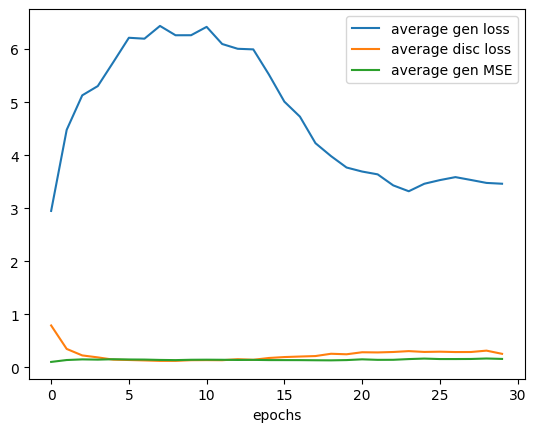

In [64]:
plt.plot(av_g_Losses, label='average gen loss')
plt.plot(av_d_Losses, label='average disc loss')
plt.plot(av_MSE, label='average gen MSE')
plt.xlabel('epochs')
plt.legend(loc='best')